# 1. 注意力分数

In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
# 遮蔽softmax操作
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上遮蔽元素来执行softmax操作"""
    if valid_lens is None:
        # 如果valid_lens为空，则对X执行softmax操作
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            # 将valid_lens扩展为与X的最后一个维度相同的形状
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            # 将valid_lens重塑为一维向量
            valid_lens = valid_lens.reshape(-1)
        # 在X的最后一个维度上进行遮蔽操作
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)   
        # 对遮蔽后的X执行softmax操作，并将形状还原为原始形状
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [3]:
# 演示此函数是如何工作
# 调用masked_softmax函数，并传入参数
masked_softmax(torch.rand(2,2,4), torch.tensor([2,3]))

tensor([[[0.3005, 0.6995, 0.0000, 0.0000],
         [0.4543, 0.5457, 0.0000, 0.0000]],

        [[0.3104, 0.2572, 0.4324, 0.0000],
         [0.2256, 0.3151, 0.4594, 0.0000]]])

In [4]:
masked_softmax(torch.rand(2,2,4), torch.tensor([[1,3],[2,4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3032, 0.3868, 0.3100, 0.0000]],

        [[0.3930, 0.6070, 0.0000, 0.0000],
         [0.2379, 0.2396, 0.2583, 0.2642]]])

In [5]:
# 加性注意力
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        # 用于转换键的线性变换
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        # 用于转换查询的线性变换
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        # 用于生成注意力分数的线性变换
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        # Dropout层，用于随机丢弃一部分注意力权重
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, queries, keys, values, valid_lens):
        # 将查询和键进行线性变换
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 执行加性操作，将查询和键相加
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        # 使用双曲正切函数激活加性操作的结果
        features = torch.tanh(features)
        # 使用线性变换生成注意力分数，并将最后一维的维度压缩掉
        scores = self.w_v(features).squeeze(-1)
        # 使用遮蔽softmax计算注意力权重
        self.attention_weights = masked_softmax(scores, valid_lens)
        # 根据注意力权重对values进行加权求和
        return torch.bmm(self.dropout(self.attention_weights), values)

In [6]:
# 演示上面的AdditiveAttention类
# 创建查询和键张量
queries, keys = torch.normal(0, 1, (2,1,20)), torch.ones((2,10,2))
# 创建值张量
values = torch.arange(40, dtype=torch.float32).reshape(1,10,4).repeat(2,1,1)  
# 创建有效长度张量
valid_lens = torch.tensor([2,6])
# 创建加性注意力对象
attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8, dropout=0.1)  
# 设置为评估模式，不使用dropout
attention.eval()
# 调用加性注意力对象的forward方法
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

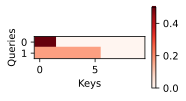

In [7]:
# 注意力权重
# 调用d2l.show_heatmaps函数，显示注意力权重的热图
d2l.show_heatmaps(attention.attention_weights.reshape((1,1,2,10)),
                 xlabel='Keys', ylabel='Queries')

In [8]:
# 缩放点积注意力
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        # Dropout层，用于随机丢弃一部分注意力权重
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, queries, keys, values, valid_lens=None):
        # 获取查询向量的维度d
        d = queries.shape[-1]
        # 计算点积注意力得分，并进行缩放
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        # 使用遮蔽softmax计算注意力权重
        self.attention_weights = masked_softmax(scores, valid_lens)
        # 根据注意力权重对values进行加权求和
        return torch.bmm(self.dropout(self.attention_weights), values)

In [9]:
# 演示上述的DotProductAttention类
# 创建查询张量
queries = torch.normal(0,1,(2,1,2))
# 创建缩放点积注意力对象
attention = DotProductAttention(dropout=0.5)
# 设置为评估模式，不使用dropout
attention.eval()
# 调用缩放点积注意力对象的forward方法
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

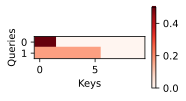

In [10]:
# 均匀的注意力权重
# 调用d2l.show_heatmaps函数，显示注意力权重的热图
d2l.show_heatmaps(attention.attention_weights.reshape((1,1,2,10)),
                 xlabel='Keys', ylabel='Queries')